# Black Friday Purchase Prediction

**Import Libraries**

In [1]:
import pickle
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

#### Data Procesing

The first step would be to load the data and take a look on the data

In [2]:
train_data = pd.read_csv("train.csv")
train_data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


Summary Statistics will help us understand the data better

In [3]:
train_data.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


from the description, it is obvious that the User_ID column does not contain usable information in itself, but as we know it can help us understand the user history which can help us predict the future purchase better. On the contrary the Product Id would not be useful in any of these scenario so we can safely drop it.

**Missing Value Imputation**
It seems obvious that the product which only belongs to 1 category does not have values for the other 2 categories so these values are not actually NA values but still we will fill them with some finite constant values like 0

In [4]:
print(train_data.isna().sum())
train_data.fillna(0, inplace=True);

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64


In [5]:
train_data.drop("Product_ID", axis=1, inplace=True)
unique_products = train_data['Product_Category_3'].unique()
len(unique_products)

16

### Data Visualization

**Purchase Average** 
<br>
Let's visualize the Purchase amount average vs city, year of stay, Marital staus, Gender and Age

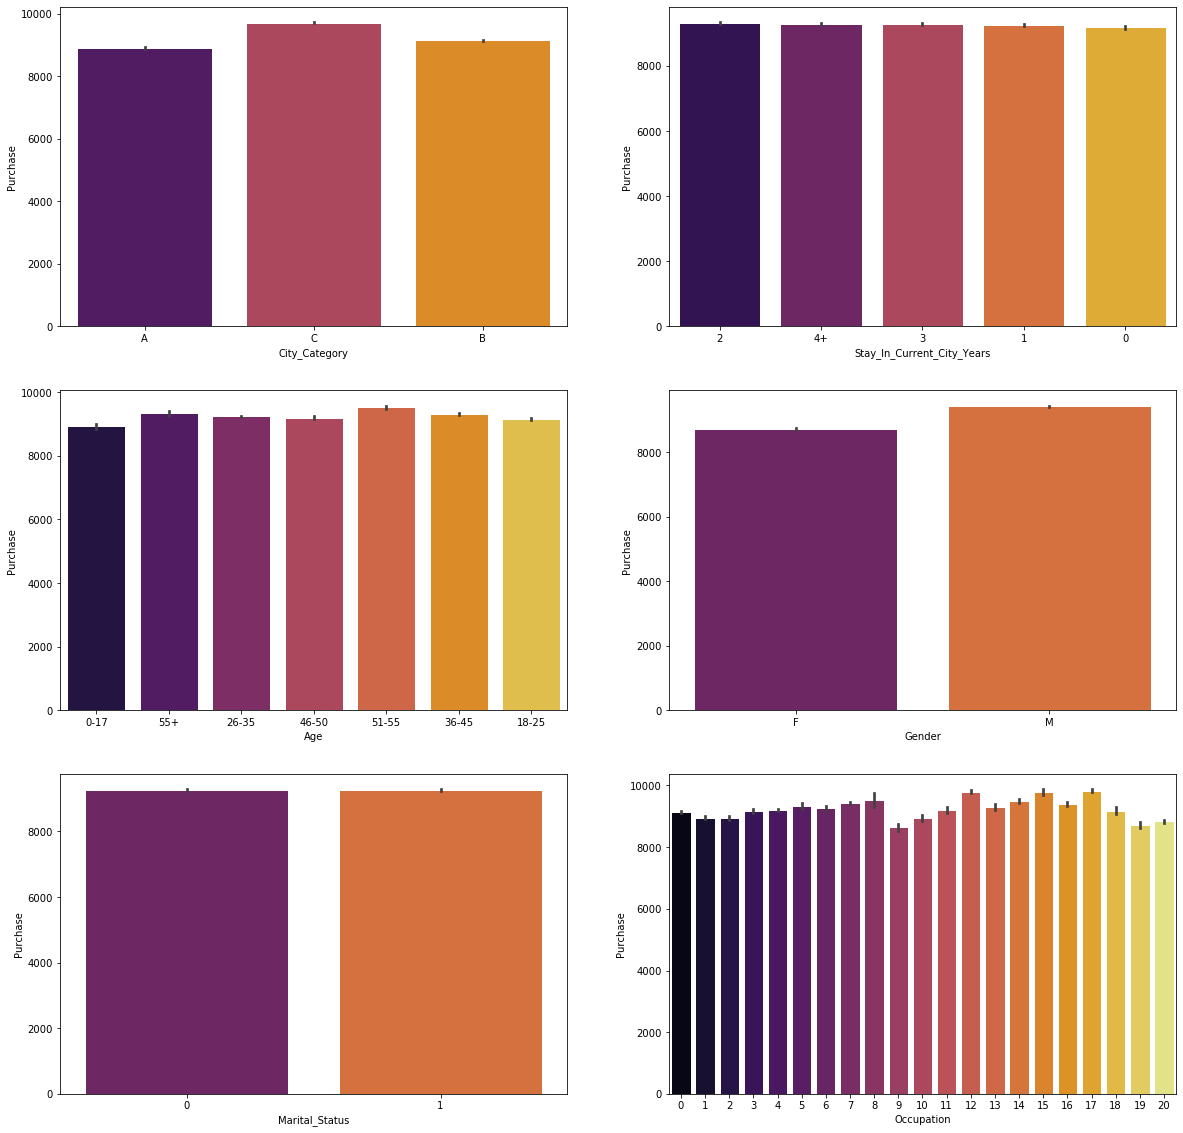

In [6]:
plt.figure(figsize=(20, 20))
plt.subplot(321)
viz_data = train_data[["City_Category", "Purchase"]]
sns.barplot(x = 'City_Category', y = 'Purchase', data = viz_data, palette = 'inferno', edgecolor = 'w')
plt.subplot(322)
viz_data = train_data[["Stay_In_Current_City_Years", "Purchase"]]
sns.barplot(x='Stay_In_Current_City_Years', y = 'Purchase', data = viz_data, palette = 'inferno', edgecolor = 'w')
plt.subplot(323)
viz_data = train_data[["Age", "Purchase"]]
sns.barplot(x='Age', y = 'Purchase', data = viz_data, palette = 'inferno', edgecolor = 'w')
plt.subplot(324)
viz_data = train_data[["Gender", "Purchase"]]
sns.barplot(x='Gender', y = 'Purchase', data = viz_data, palette = 'inferno', edgecolor = 'w')
plt.subplot(325)
viz_data = train_data[["Marital_Status", "Purchase"]]
sns.barplot(x='Marital_Status', y = 'Purchase', data = viz_data, palette = 'inferno', edgecolor = 'w')
plt.subplot(326)
viz_data = train_data[["Occupation", "Purchase"]]
sns.barplot(x='Occupation', y = 'Purchase', data = viz_data, palette = 'inferno', edgecolor = 'w')

The visualzation does show that the purchase amount average is affected by different factor but not significantly hence the purchase amount is collectivey affected by the given attributes. 

# Feature Engineering

In order to use the user history we will have to create a user to product mapping where we need to compute average purchase amount per category for the each user. there are total of 18 product categories. so we would create a dataset for the user history which will contain this maping information.

#### User History Dataset
Create the new dataset to store user history per product. The new dataset will contain a lot of misiing value which indicates no deirect mapping between the user and the product category because no past purchase. We would replace those vaues by 0. FInally we will save the user history so it can be loaded during test time.

In [58]:
user_history = train_data[["User_ID", "Product_Category_1", "Purchase"]]
user_history.columns = ["User_ID", "Product_Category", "Purchase"]
user_history=user_history.groupby(["User_ID", "Product_Category"]).mean()
user_history.fillna(0)
user_history.to_csv("user_history.csv")

The last step of feature enginneing is to add the averge purchase amount for each user-product category

In [9]:
def find_average_purchase(x):
    try:
        return user_history.xs(x["User_ID"]).xs(x["Product_Category_1"]) 
    except:
        return 0
train_data["Average_Category_Purchase"] = train_data.apply(find_average_purchase, axis=1)

#### Data Transformation

The column names and the summary statistics suggest that the many of those features are categorical features with no relative order such as Gender, Age, Occupation, City_Category,  Marital_Status. Product_Category_1, Product_Category_2 and Product_Category_3. We need to transform those columns to categorial variable.
<br>
Stay_In_Current_City_Years might seem like a categorical column but it has a relative ordering so we will keep it same but just replace 4+ years to 4.

In [10]:
# convert the integer coluns to string so that pands dummy encoding can convert them.
train_data.Occupation = train_data.Occupation.apply(str)
train_data.Marital_Status = train_data.Marital_Status.apply(str)
train_data.Product_Category_1 = train_data.Product_Category_1.apply(str)
train_data.Product_Category_2 = train_data.Product_Category_2.apply(str)
train_data.Product_Category_3 = train_data.Product_Category_3.apply(str)
train_data.Stay_In_Current_City_Years.replace("4+", 4, inplace=True)
transformed_data = pd.get_dummies(train_data)

Information about this columns transformation is very important because it is required during the test evaluation. So we will store the feature names to an external storage so it can be retrieved at any point.

In [12]:
with open("training_features.txt", "w") as file:
    for col in transformed_data.columns:
        file.write("%s\n" % col)

# Prediction Modeling 

Now we will create a model for predicting purchase amount based on the other features. Since our target is a continous value we need to build a regression model. Since the dataset is large using SVM regression would not be a good idea if using non-linear kernel so we can try Random Forest with CART and XGBoost Regression

**feature-target and train-validation split**

In [43]:
target = transformed_data["Purchase"].values
features = transformed_data.drop("Purchase", axis=1).values
train_features, val_features, train_targets, val_targets = train_test_split(features, target)

### Create Random Forest Model

In [44]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=1, min_samples_split=100, n_jobs=8)
rf_model.fit(train_features, train_targets)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=100, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=8, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

**Training and Validation RMSE**

In [49]:
train_pred = rf_model.predict(train_features)
train_mse = mean_squared_error(train_pred, train_targets)
val_pred = rf_model.predict(val_features)
val_mse = mean_squared_error(val_pred, val_targets)
print("Training RMSE=%.2f"%np.sqrt(train_mse))
print("Training R Square=%.4f" % r2_score(train_pred, train_targets))
print("Validation RMSE=%.2f"%np.sqrt(val_mse))
print("Validation R Square=%.4f" % r2_score(val_pred, val_targets))

Training RMSE=2349.80
Training R Square=0.7061
Validation RMSE=2568.81
Validation R Square=0.6485


**Save the Model**

In [50]:
filename = 'random_forest.pkl'
pickle.dump(rf_model, open(filename, 'wb'))

### Create XGBoost Model

In [96]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.2, learning_rate = 0.1, 
                          max_depth = 15, alpha = 0.15, n_estimators = 100)
xgb_model.fit(train_features,train_targets)

XGBRegressor(alpha=0.15, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [95]:
train_pred = xgb_model.predict(train_features)
train_mse = mean_squared_error(train_pred, train_targets)
val_pred = xgb_model.predict(val_features)
val_mse = mean_squared_error(val_pred, val_targets)
print("Training RMSE=%.2f"%np.sqrt(train_mse))
print("Training R Square=%.4f" % r2_score(train_pred, train_targets))
print("Validation RMSE=%.2f"%np.sqrt(val_mse))
print("Validation R Square=%.4f" % r2_score(val_pred, val_targets))

Training RMSE=2265.20
Training R Square=0.7263
Validation RMSE=2611.18
Validation R Square=0.6313


**Save the Model**

In [83]:
filename = 'xgboost.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))

# Model Evaluation on Test Data

To evaluate the model on the test data, we first need to pefrom same pre-processing step on the test data as was done on train data.

In [74]:
test_data = pd.read_csv("train.csv")
test_data.drop("Product_ID", axis=1, inplace=True)
test_data.head()

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,M,55+,16,C,4+,0,8,NaN,NaN,7969


**Feature Transformation**

In [75]:
test_data.Occupation = train_data.Occupation.apply(str)
test_data.Marital_Status = train_data.Marital_Status.apply(str)
test_data.Product_Category_1 = train_data.Product_Category_1.apply(str)
test_data.Product_Category_2 = train_data.Product_Category_2.apply(str)
test_data.Product_Category_3 = train_data.Product_Category_3.apply(str)
test_data.Stay_In_Current_City_Years.replace("4+", 4, inplace=True)
test_data = pd.get_dummies(test_data)

One of the important point while performing test evaluation when using categorical column transformation is to do match the same dummy encoding as was done during training phase. This can be acheived by adding the missing column from the training to the test data.

In [76]:
columns = []
with open("training_features.txt", "r") as file:
    for col in file.readlines():
        columns.append(col.strip())
    

for col in columns:
    if col not in transform_data.columns:
        transform_data[col] = 0

**Get the User history**

In [77]:
user_history = pd.read_csv("user_history.csv")

def find_average_purchase(x):
    try:
        return user_history.xs(x["User_ID"]).xs(x["Product_Category_1"]) 
    except:
        return 0
test_data["Average_Category_Purchase"] = test_data.apply(find_average_purchase, axis=1)

### Predict

In [79]:
test_data = test_data.values
rf_model = pickle.load(open("random_forest.pkl", 'rb'))
pred = rf_model.predict(test_data)

In [80]:
pred[0:10]

array([73.92519467, 47.63161898, 47.63161898, 47.63161898, 47.63161898,
       47.63161898, 47.63161898, 47.63161898, 47.63161898, 47.63161898])

In [84]:
test_data = test_data
xgb_model = pickle.load(open("xgboost.pkl", 'rb'))
pred = xgb_model.predict(test_data)

In [85]:
pred[0:10]

array([73.92519467, 47.63161898, 47.63161898, 47.63161898, 47.63161898,
       47.63161898, 47.63161898, 47.63161898, 47.63161898, 47.63161898])